## PROBLEM STATEMENT

**Emergency vs Non-Emergency Vehicle Classification**

Fatalities due to traffic delays of emergency vehicles such as ambulance & fire brigade is a huge problem. In daily life, we often see that emergency vehicles face difficulty in passing through traffic. So differentiating a vehicle into an emergency and non emergency category can be an important component in traffic monitoring as well as self drive car systems as reaching on time to their destination is critical for these services.


## Data Description
- '0' class refers to non-emergency vehicles
- '1' class refers to emergency vehicles .Eg Police car,ambulance ,etc


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
import seaborn as sns
import os

import sklearn
import os 
from PIL import Image
from sklearn.model_selection import train_test_split,StratifiedKFold
  
import os,cv2
from IPython.display import Image

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D , BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.initializers import glorot_normal,glorot_uniform, he_normal, he_uniform
from keras.optimizers import Adamax,Adam, Adadelta, Adagrad, RMSprop, Nadam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.regularizers import l2,l1
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from keras.applications.vgg16 import VGG16
from keras.applications import NASNetLarge
from keras import optimizers

## Loading Dataset

In [4]:
test_labels = pd.read_csv("../input/jantahackcomputervision/test_vc2kHdQ.csv")
submission = pd.read_csv("../input/jantahackcomputervision/ss.csv")
train_labels = pd.read_csv("../input/jantahackcomputervision/train_SOaYf6m/train.csv")


train_labels["emergency_or_not"] = train_labels["emergency_or_not"].astype(str)
submission["emergency_or_not"] = submission["emergency_or_not"].astype(str)

random = [ '0' if i%4==0 else '1' for i in range(706)]
submission["emergency_or_not"]  = random

In [5]:
train_labels.head(5)

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [6]:
test_labels.head()

,image_names
0,1960.jpg
1,668.jpg
2,2082.jpg
3,808.jpg
4,1907.jpg


0    965
1    681
Name: emergency_or_not, dtype: int64


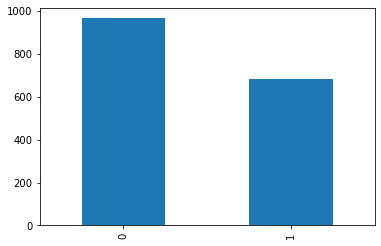

In [7]:
## Looking at number of classes in the training data
train_labels["emergency_or_not"].value_counts().plot(kind="bar");

print(train_labels["emergency_or_not"].value_counts())

**Both the classes i.e 0 and 1 are in comparable amount hence we are not dealing with imbalanced classification**

## Visualising some of the images and their classes 

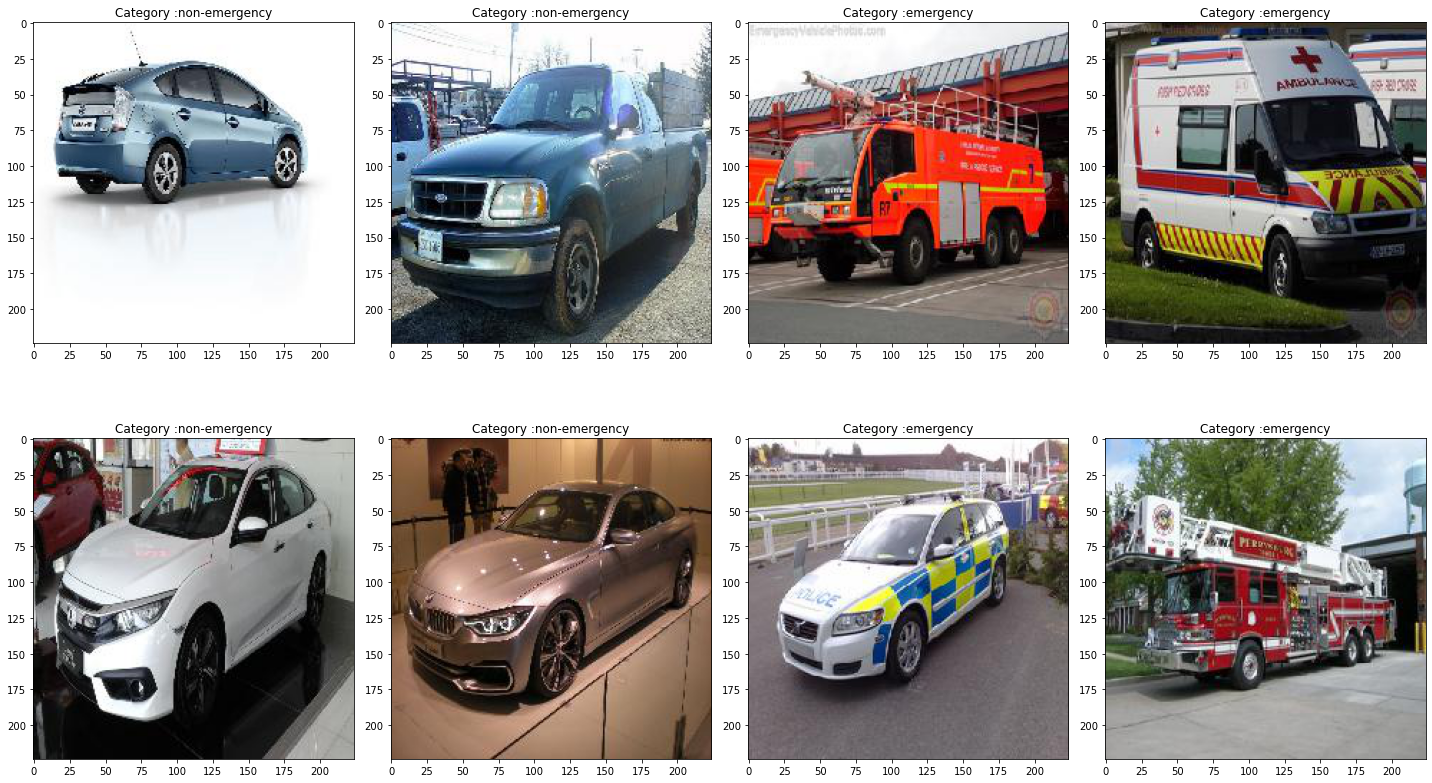

In [8]:
from PIL import Image
def view_imgs(df,rows,cols):
    IMAGE_DIR ="../input/jantahackcomputervision/train_SOaYf6m/images/"
    axes=[]
    fig=plt.figure(figsize=(20,12))    
    for i in range(rows*cols):
        idx = np.random.randint(len(df), size=1)[0]
        image_name , label = df.loc[idx,"image_names"],df.loc[idx,"emergency_or_not"]
        image = Image.open(IMAGE_DIR+image_name)
        label = "emergency" if label=='1' else "non-emergency"
        axes.append( fig.add_subplot(rows, cols, i+1))
        subplot_title=("Category :"+str(label))
        axes[-1].set_title(subplot_title)  
        plt.imshow(image)
    fig.tight_layout()  
    plt.show()
        
        
view_imgs(train_labels,2,4)

## MODEL 1 : VGG16
- **Using Vgg16 pre-trained network and then fine tuning the top layers of pre-trained network**
- Below image shows the architecture of VGG16

<img src="https://www.researchgate.net/profile/Clifford_Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg">


- Pretrained network means we will use the weights which are provided by-default by imagenet .Since it was trained on Imagenet which has lots of classes using default weights will speed up the training process.Because the earlier layers of any CNN model recognizes basic features like edges,curves,etc then further layers combines them to make object like shape such as box,rectangle,circle,etc . Only the deeper layers are more specific to what we are building.

- Since Deeper layers are specific to our problem we will fine-tune them that means we will freeze the earlier layers and only train the last Conv layer of vgg and the FC layer with very small weight updates.

For Fine Tuning I used the below keras blog as reference it explains fine tuning in depth:<br>
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

## Loading Images 

- We use ImageDataGenerator class to load images and apply augmentations.


In [9]:
## Shuffling dataframe
train_labels = train_labels.sample(frac=1).reset_index()

datagen = ImageDataGenerator(rescale=1./255)
batch_size=64
img_dir = "../input/jantahackcomputervision/train_SOaYf6m/images"

train_generator=datagen.flow_from_dataframe(dataframe=train_labels[:1318],directory=img_dir,x_col='image_names',
                                            class_mode=None,batch_size=batch_size,
                                            target_size=(224,224),shuffle=False)

## class_mode is none since we only need the bottle_neck features 


validation_generator = datagen.flow_from_dataframe(dataframe=train_labels[1318:],directory=img_dir,x_col='image_names',
                                                class_mode=None,batch_size=32,
                                                target_size=(224,224),shuffle=False)

Found 1318 validated image filenames.
Found 328 validated image filenames.


## Bottleneck Predictions

In [10]:
vgg16 = VGG16(weights="imagenet",include_top=False,input_shape=(224,224,3))

for layers in vgg16.layers:
    layers.trainable = False
    

## Looking at the model structure
vgg16.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [11]:
bottleneck_features_train = vgg16.predict(train_generator,verbose=1)
bottleneck_features_validation = vgg16.predict(validation_generator,verbose=1)
print(bottleneck_features_train.shape,bottleneck_features_validation.shape)

11/11 [==============================] - 1s 125ms/step
(1318, 7, 7, 512) (328, 7, 7, 512)


### Creating Fully Connected layer i.e Top Classifier Architecture and training it for stable weights 
- The reason for not directly fine tuning is that if we try to fine tune the Top Classifier with randomly initialized weights our pretrained weights will get destroyed and it will lead to the problem of Exploding Gradients. Hence it's better to first train the top-classifier for stable weights then fine tune with small learning rate and SGD or RMSProp so that the magnitude of updates remain small and our peviously learned weights do not get wrecked.

In [12]:
train_data = bottleneck_features_train.copy()
train_class = train_labels.loc[:1317,"emergency_or_not"]

validation_data = bottleneck_features_validation.copy()
validation_class = train_labels.loc[1318:,"emergency_or_not"]

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(2048,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
# Using checkpoints to save the best model where we are monitoring validation accuracy 
# i.e we will save the model corresponding to max validation'accuracy 

from keras.callbacks import ModelCheckpoint
filename = "./bottle_neck_best_wts.hdf5"
checks = ModelCheckpoint(filename,monitor="val_accuracy",verbose=1,
                         save_best_only=True,mode="max",save_weights_only=True)

model.fit(train_data, train_class,
          epochs=2,
          batch_size=32,
          validation_data=(validation_data, validation_class),
         callbacks=[checks])


## Fine Tuning Last conv block of VGG with stable weights of TopClassifiers
- Final Model = VGG(fine tune) + TopClassifier(stable wts)

In [14]:
## After instantiating the VGG base and loading its weights, 

vgg = VGG16(weights="imagenet",include_top=False,input_shape=(224,224,3))
for layer in vgg.layers[:-4]:
    layer.trainable = False

## we add our previously trained fully-connected classifier on top of it
final_model = Sequential()
final_model.add(vgg)


## Trained Classifier
top_model = Sequential()
top_model.add(Flatten(input_shape=final_model.output_shape[1:]))
top_model.add(Dense(2048,activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1,activation="sigmoid"))
top_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              51382272  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 51,384,321
Trainable params: 51,384,321
Non-trainable params: 0
_________________________________________________________________


In [15]:
# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning

top_model_weights_path = "../input/cv-av-models/bottle_neck_best_wts.hdf5"
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
final_model.add(top_model)
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 51384321  
Total params: 66,099,009
Trainable params: 58,463,745
Non-trainable params: 7,635,264
_________________________________________________________________


### Compiling the model with a SGD/momentum optimizer with a very slow learning rate.

In [16]:
final_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

### Now for final training we used data augmentation techniques

**Data Augmentation** :- In normal terms we take a single image and apply some transformations/edit them to create new images this will help us to create more data and to significantly increase the diversity of data available for training models, without actually collecting new data.

### **Augmentations Used**
- Horizontal Flipping
- Zooming
- Shear

## Image Data Generator with augmentation

In [36]:
# prepare data augmentation configuration

def return_data_generators(img_width,img_height,train_labels,batch_size=16,class_mode="binary"):
    """
    img_width,img_height : - image dimension to be resized to this sizes during data loading
    
    returns ImageDatagenerators for training and testing purpose
    
    """
    
    
    train_labels = train_labels.sample(frac=1).reset_index()

    train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1./255)


    img_dir = "../input/jantahackcomputervision/train_SOaYf6m/images"


    train_generator = train_datagen.flow_from_dataframe(dataframe=train_labels[:1318],directory=img_dir,x_col='image_names',
                                                y_col='emergency_or_not',class_mode=class_mode,batch_size=batch_size,
                                                target_size=(img_width,img_height),shuffle=True)

    validation_generator = test_datagen.flow_from_dataframe(dataframe=train_labels[1318:],directory=img_dir,x_col='image_names',
                                                    y_col='emergency_or_not',class_mode=class_mode,batch_size=batch_size,
                                                    target_size=(img_width,img_height),shuffle=True)
    
    test_generator = test_datagen.flow_from_dataframe(dataframe=test_labels,directory=img_dir,x_col='image_names',
                                                class_mode=None,batch_size=batch_size,
                                                target_size=(img_width,img_height),shuffle=False)
    
    return train_generator,validation_generator,test_generator

In [18]:
batch_size = 32
epochs = 30

train_generator,validation_generator,test_generator = return_data_generators(224,224,train_labels,batch_size)

## Checkpoints
filename = "./fine_tuned.hdf5"

checks = ModelCheckpoint(filename,monitor="val_accuracy",verbose=1,
                         save_best_only=True,mode="max")

# fine-tune the model
history_finetune = final_model.fit_generator(train_generator,epochs=epochs,
                              validation_data=validation_generator,
                             callbacks=[checks],verbose=1)

Found 1318 validated image filenames belonging to 2 classes.
Found 328 validated image filenames belonging to 2 classes.
Found 706 validated image filenames.
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 0.2216 - accuracy: 0.9484
Epoch 00001: val_accuracy improved from -inf to 0.99390, saving model to ./fine_tuned.hdf5
42/42 [==============================] - 17s 416ms/step - loss: 0.2216 - accuracy: 0.9484 - val_loss: 0.0393 - val_accuracy: 0.9939
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 0.1900 - accuracy: 0.9408
Epoch 00002: val_accuracy did not improve from 0.99390
42/42 [==============================] - 17s 405ms/step - loss: 0.1900 - accuracy: 0.9408 - val_loss: 0.0491 - val_accuracy: 0.9909
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9507
Epoch 00003: val_accuracy did not improve from 0.99390
42/42 [==============================] - 17s 399ms/step - loss: 0.1528 - accuracy: 0.9507 - val

Epoch 30/30
42/42 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9977
Epoch 00030: val_accuracy did not improve from 0.99390
42/42 [==============================] - 16s 393ms/step - loss: 0.0128 - accuracy: 0.9977 - val_loss: 0.0506 - val_accuracy: 0.9909


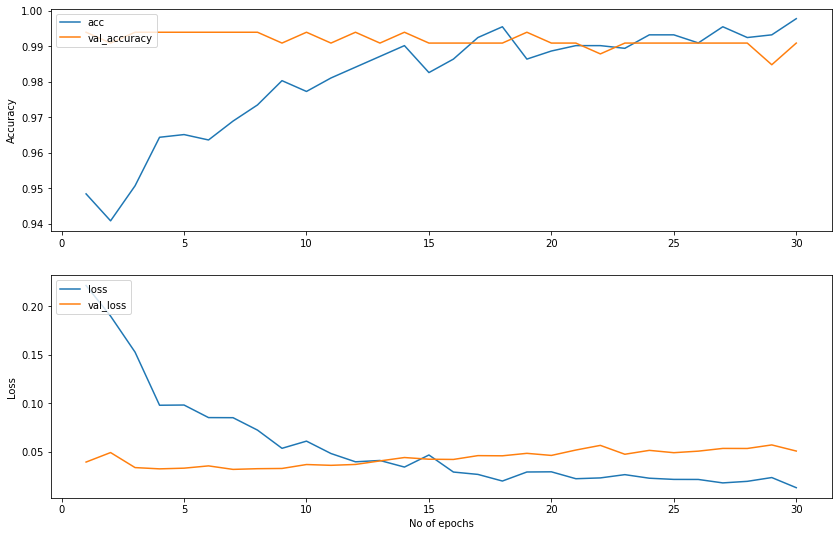

In [24]:
## TRY THIS FUNCTION ONCE

def plot_loss_acc(history,epochs,filename):
    fig = plt.figure(figsize=(14,9))

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)
    
    epoch = list(range(1,epochs+1,1))
    losses = history.history["loss"]
    val_losses = history.history["val_loss"]

    accuracies = history.history["accuracy"]
    val_accs = history.history["val_accuracy"]

    
    ax1.plot(epoch, accuracies, label="acc")
    ax1.plot(epoch, val_accs, label="val_accuracy")
    ax1.legend(loc=2)
    ax1.set_ylabel("Accuracy")
    
    ax2.plot(epoch,losses, label="loss")
    ax2.plot(epoch,val_losses, label="val_loss")
    ax2.legend(loc=2)
    ax2.set_xlabel("No of epochs")
    ax2.set_ylabel("Loss")

    
    
    plt.savefig("./"+filename+".png", dpi=300, bbox_inches='tight')
    plt.show()

    
plot_loss_acc(history_finetune,30,"keras_finetune_vgg")

## INFERENCE FROM GRAPH
- The oscillations are due to Stochastic Gradient Descent as the weights are updated after each example
- The model starts overfitting after apprxoimately 15 epochs.

## We tried L2 rgularization
- As there is a large gap between validation and train accuracy in attempt to reduce overfitting to  the model for better accuracy and predictions on unseen data


## MODEL 2 : VGG16 wih dropout and regularization

In [42]:
## VGG16 with l2 regularization

## After instantiating the VGG base and loading its weights, 

vgg = VGG16(weights="imagenet",include_top=False,input_shape=(224,224,3))
for layer in vgg.layers:
    layer.trainable = False

    
model_l2 = Sequential()
model_l2.add(vgg)


## Trained Classifier
top_model = Sequential()
top_model.add(Flatten(input_shape=model_l2.output_shape[1:]))
top_model.add(Dense(2048,activation='relu',kernel_initializer=glorot_uniform(), kernel_regularizer=l2()))
top_model.add(Dropout(0.5))
top_model.add(Dense(2,activation="softmax",kernel_initializer=glorot_uniform(), kernel_regularizer=l2()))

# top_model_weights_path = "../input/cv-av-models/bottle_neck_best_wts.hdf5"
# top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model_l2.add(top_model)
model_l2.summary()

model_l2.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

## Checkpoints
filename = "./fine_tuned_l2_augnmentation.hdf5"

checks = ModelCheckpoint(filename,monitor="val_accuracy",verbose=1,
                         save_best_only=True,mode="max")

train_generator,validation_generator,test_generator = return_data_generators(224,224,train_labels,32,"categorical")

# fine-tune the model
history_l2 = model_l2.fit_generator(train_generator,epochs=30,validation_data=validation_generator,verbose=1,callbacks=[checks])

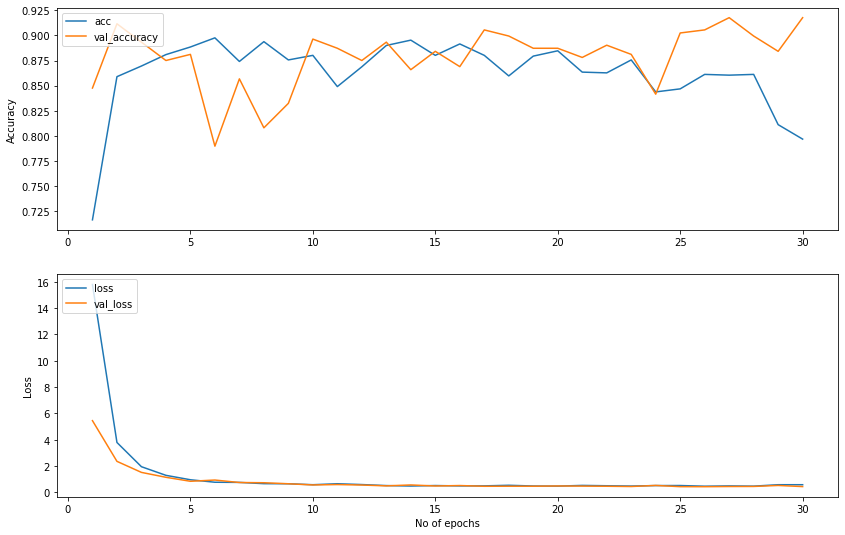

In [43]:
plot_loss_acc(history_l2,30,"vgg_l2")

## Trying an advanced model i.e NASnet Large

- " The key contribution of this work is the design of a new search space (which we call the “NASNet search space”) which enables transferability. In our experiments, we search for the best convolutional layer (or “cell”) on the CIFAR-10 dataset and then apply this cell to the ImageNet dataset by stacking together more copies of this cell, each with their own parameters to design a convolutional architecture, which we name a “NASNet architecture”. 

* The NASNet architechure introduces the design of a new search space which the researchers called the **NASNet search space** which enables transferability. 

* We picked this model because it searches it's own architecture based on problem and data. Our data set is small and also the problem is difficult in itself, we have to classify objects of same type i.e both are vehicles only either emergency or non-emergency so we tried experimenting with this model which resulted in good predictions.

## MODEL 3 : NASnet Large without Dropout and regularization
## MODEL 4 : NASnet Large with Dropout and regularization


In [44]:
nasnet = NASNetLarge(weights = "imagenet", input_shape = (331, 331, 3), include_top = False)
for layer in nasnet.layers:
    layer.trainable = False

nasnet_model = Sequential()
 

## Adding a covolutional base with l2 regularzer and FC layer on top of it
nasnet_model.add(nasnet)

nasnet_model.add(Conv2D(1024, (3, 3), activation = "relu"))
nasnet_model.add(BatchNormalization())
nasnet_model.add(MaxPooling2D(2, 2))
 
nasnet_model.add(Flatten())
  
nasnet_model.add(Dense(2048, activation = "relu",kernel_regularizer=l2()))
nasnet_model.add(BatchNormalization())
nasnet_model.add(Dropout(0.5))
 
nasnet_model.add(Dense(256, activation = "relu",kernel_regularizer=l2()))
nasnet_model.add(BatchNormalization()) 
nasnet_model.add(Dropout(0.5))
 
nasnet_model.add(Dense(1, activation = "sigmoid"))
 
nasnet_model.summary()

343613440/343610240 [==============================] - 4s 0us/step
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 11, 11, 4032)      84916818  
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 1024)        37159936  
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 1024)        4096      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 1024)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 2048)              33556480  
____________________________________________________

In [46]:
## Compiling and training the model

## Checkpoints
filename = "./nasnet_l2.hdf5"

train_generator,validation_generator,test_generator = return_data_generators(331,331,train_labels,32)

checks = ModelCheckpoint(filename,monitor="val_accuracy",verbose=1,
                         save_best_only=True,mode="max")

epochs = 20
nasnet_model.compile(loss = 'binary_crossentropy',
              optimizer = "adam",
              metrics = ['accuracy']
              )

history_nasnet = nasnet_model.fit_generator(train_generator,epochs=epochs,
                              validation_data=validation_generator,
                             callbacks=[checks],verbose=1)

Found 1318 validated image filenames belonging to 2 classes.
Found 328 validated image filenames belonging to 2 classes.
Found 706 validated image filenames.
Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 4.5109 - accuracy: 0.9211
Epoch 00001: val_accuracy improved from -inf to 0.95732, saving model to ./nasnet_l2.hdf5
42/42 [==============================] - 58s 1s/step - loss: 4.5109 - accuracy: 0.9211 - val_loss: 3.1961 - val_accuracy: 0.9573
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 2.2628 - accuracy: 0.9355
Epoch 00002: val_accuracy did not improve from 0.95732
42/42 [==============================] - 49s 1s/step - loss: 2.2628 - accuracy: 0.9355 - val_loss: 2.1621 - val_accuracy: 0.9543
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 1.6569 - accuracy: 0.9560
Epoch 00003: val_accuracy improved from 0.95732 to 0.96341, saving model to ./nasnet_l2.hdf5
42/42 [==============================] - 52s 1s/step - loss: 1.6

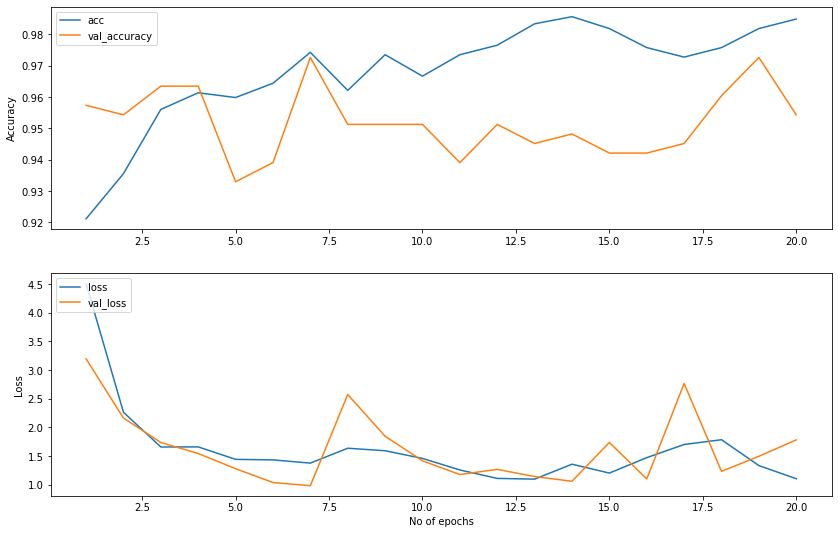

In [49]:
plot_loss_acc(history_nasnet,20,"nasnet_l2")

## MODEL 5 :
- A normal CNN architecture made by us which was trained for stratified 5 fold cross validation
- Then we took the mode of this 5 predictions .
- It was just a test and this model gave the accuracy of 0.944 on the public leaderboard

## Data Preparation for stratified split

In [50]:
train_dataset = train_labels.copy()
test_dataset = test_labels.copy()

train_image_name = list(train_dataset["image_names"])
test_image_name = list(test_dataset["image_names"])

print(len(train_image_name),len(test_image_name))

train_images = list()
test_images = list()
train_image_res = list()

dirname = "../input/jantahackcomputervision/train_SOaYf6m/images"

for i,filename in enumerate(train_image_name):
    img = cv2.imread(os.path.join(dirname,filename))
    y_val = int(train_dataset[train_dataset.image_names == filename]["emergency_or_not"])
    train_image_res.append(y_val)
    train_images.append(img)
    #print(i+1)


for i,filename in enumerate(test_image_name):
    img = cv2.imread(os.path.join(dirname,filename))
    test_images.append(img)
    #print(i+1)
    

train_images = np.array(train_images)
test_images = np.array(test_images)
train_image_res = np.array(train_image_res)
    
print(train_images.shape,test_images.shape,train_image_res.shape)

1646 706
(1646, 224, 224, 3) (706, 224, 224, 3) (1646,)


In [54]:
# Creating fold_model

fold_model = Sequential()
fold_model.add(Conv2D(32,(3,3),input_shape=(224, 224,3)))
fold_model.add(Activation('relu'))
fold_model.add(MaxPooling2D(pool_size=(2, 2)))

fold_model.add(Conv2D(32,(3,3)))
fold_model.add(Activation('relu'))
fold_model.add(MaxPooling2D(pool_size=(2, 2)))

fold_model.add(Conv2D(128,(3,3)))
fold_model.add(Activation('relu'))
fold_model.add(MaxPooling2D(pool_size=(2, 2)))

fold_model.add(Conv2D(512,(5,5)))
fold_model.add(Activation('relu'))
fold_model.add(MaxPooling2D(pool_size=(2, 2)))

fold_model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
fold_model.add(Dense(512))
fold_model.add(Activation('relu'))
fold_model.add(Dropout(0.5))
fold_model.add(Dense(2))
fold_model.add(Activation('softmax'))

fold_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


filename = "./kfold.hdf5"
checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping_monitor = EarlyStopping(monitor='val_accuracy',patience=7)
callbacks_list = [early_stopping_monitor, checkpoint]


In [55]:
## Training and predictions
K = 5

skf = StratifiedKFold(n_splits=K, shuffle=True, random_state = 7)
new_submission = pd.DataFrame()

X = train_images
Y = train_image_res
X_test = test_images

j = 1

y_valid = None 
X_valid = None

for (train_data_image, test_data_image) in skf.split(X, Y):
    
    y_train, y_valid = Y[train_data_image], Y[test_data_image]
    X_train, X_valid = X[train_data_image], X[test_data_image]
    
    y_train = to_categorical(y_train, num_classes=2)
    y_valid = to_categorical(y_valid, num_classes=2)
    
    fold_model_history = fold_model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                        epochs=25,callbacks=[callbacks_list],verbose=1)
    
    new_submission["predict" + str(j)] = np.argmax(fold_model.predict(X_test,verbose=1), axis = 1)
    
    j = j + 1
    



Epoch 1/25
41/42 [============================>.] - ETA: 0s - loss: 831.6469 - accuracy: 0.6014
Epoch 00001: val_accuracy improved from -inf to 0.64848, saving model to ./kfold.hdf5
42/42 [==============================] - 2s 59ms/step - loss: 829.1211 - accuracy: 0.6011 - val_loss: 0.9305 - val_accuracy: 0.6485
Epoch 2/25
41/42 [============================>.] - ETA: 0s - loss: 1.0986 - accuracy: 0.6113
Epoch 00002: val_accuracy did not improve from 0.64848
42/42 [==============================] - 2s 39ms/step - loss: 1.0952 - accuracy: 0.6125 - val_loss: 8.8034 - val_accuracy: 0.5848
Epoch 3/25
41/42 [============================>.] - ETA: 0s - loss: 1.0677 - accuracy: 0.5991
Epoch 00003: val_accuracy did not improve from 0.64848
42/42 [==============================] - 2s 39ms/step - loss: 1.0662 - accuracy: 0.5995 - val_loss: 0.7038 - val_accuracy: 0.6333
Epoch 4/25
41/42 [============================>.] - ETA: 0s - loss: 1.7035 - accuracy: 0.5854
Epoch 00004: val_accuracy did not 

Epoch 8/25
41/42 [============================>.] - ETA: 0s - loss: 0.0676 - accuracy: 0.9802
Epoch 00008: val_accuracy did not improve from 0.99696
23/23 [==============================] - 0s 12ms/step


NameError: name 'final_res' is not defined

In [65]:
submission = pd.DataFrame()
submission["image_names"] = test_image_name
submission["emergency_or_not"] = new_submission.mode(axis=1)
submission.to_csv("./sub.csv",index = False)
submission.head()

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,1
2,2082.jpg,0
3,808.jpg,1
4,1907.jpg,0
